## Esercizio 12.1
Studio l'efficienza di una rete neurale profonda 4 strati, al variare dell'algoritmo di ottimizzazione, nel riconoscimento di numeri scritti a mano

In [10]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.set_random_seed(seed)

##### Importazione dataset training

In [11]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [13]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam

def compile_model(OPTMZ):
    # create the model
    model = create_DNN()
    # compile the model
    model.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = OPTMZ,
                  metrics = ['accuracy'])
    return model

##### Costruzione delle reti
Le reti studiate hanno tutte la stessa struttura di layer interni:
- layer 'dense' di 400 neuroni con attivazione 'relu'
- layer 'dense' di 100 neuroni con attivazione 'relu'
- dropout 
- layer di output di 10 neuroni (10 cifre da classificare)

Ho deciso di utilizzare i seguenti ottimizzatori:
- SGD
- SGD con momento di Nesterov
- Adam
- Adagrad

In [5]:
# training parameters
batch_size = 32
epochs = 5

# construct a dictionary of models
models = {'SGD': compile_model(SGD()),
         'SGD w/ Nest': compile_model(SGD(momentum=0.1, nesterov=True)),
         'Adam': compile_model(Adam()),
         'Adagrad': compile_model(Adagrad()),
         }

# construct a dictionary for the histories
histories = {}

for label, model in models.items():
    histories[label] = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))
    print(label + ' model fitted successfully!')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
SGD model fitted successfully!
SGD w/ Nest model fitted successfully!
Adam model fitted successfully!
Adagrad model fitted successfully!


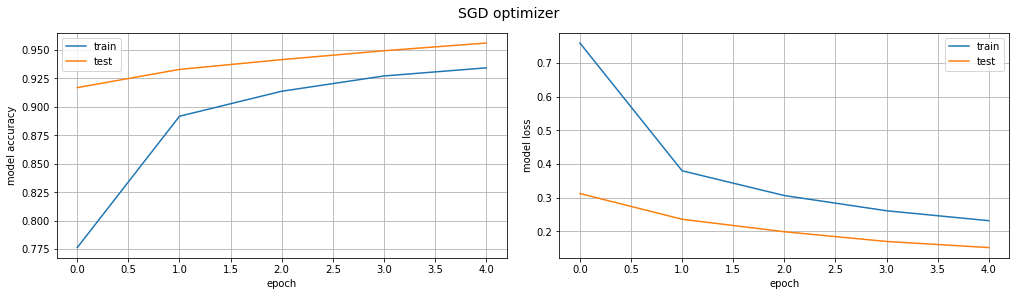

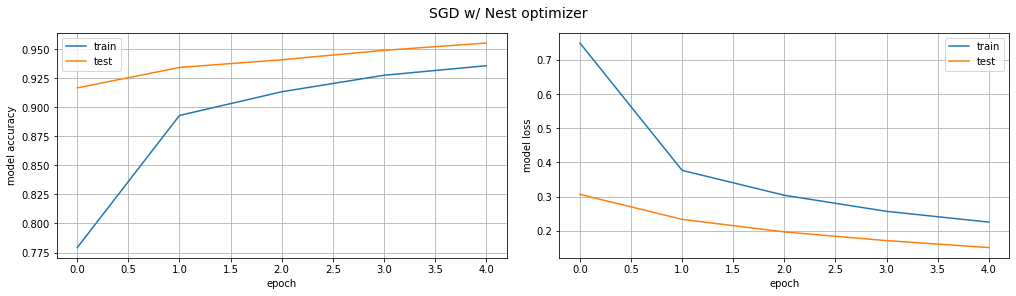

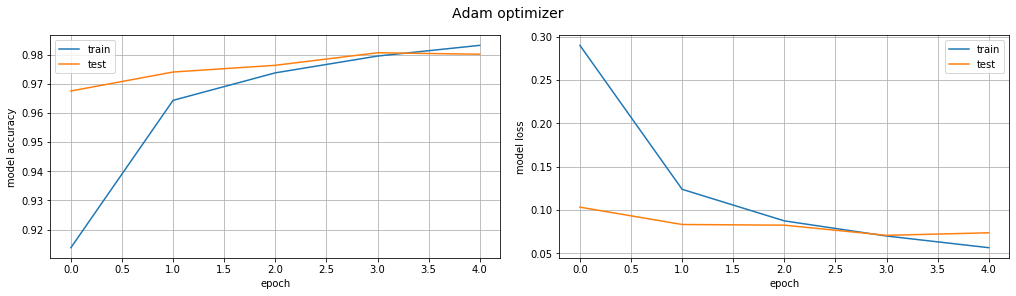

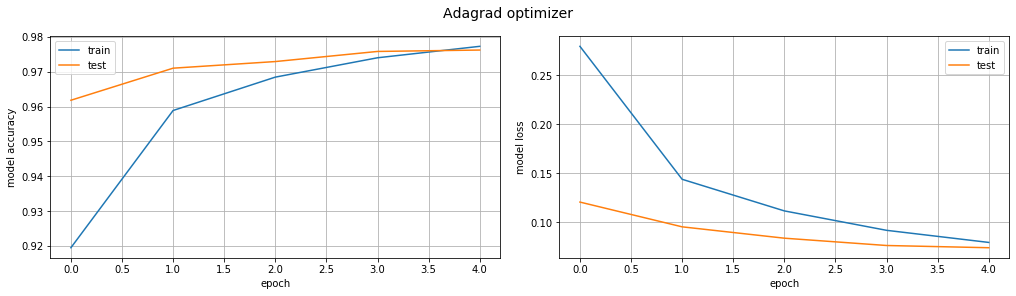

In [6]:
for label, history in histories.items():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), constrained_layout=True)
    
    fig.suptitle(label + ' optimizer', fontsize=14)
    # summarize history for accuracy
    ax = axs[0]
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='test')
    ax.set_ylabel('model accuracy')
    ax.set_xlabel('epoch')
    ax.legend()
    ax.grid()

    # summarize history for loss
    ax = axs[1]
    ax.plot(history.history['loss'], label='train')
    ax.plot(history.history['val_loss'], label='test')
    ax.set_ylabel('model loss')
    ax.set_xlabel('epoch')
    ax.legend()
    ax.grid()
    
    plt.show()

In [7]:
for label, model in models.items():
    
    print(label + ' optimizer')

    # evaluate model
    score = model.evaluate(X_test, Y_test, verbose=0)

    print('Test loss: {:.3f}'.format(score[0]))
    print('Test accuracy: {:.3f}'.format(score[1]))
    print()

SGD optimizer
Test loss: 0.152
Test accuracy: 0.956

SGD w/ Nest optimizer
Test loss: 0.151
Test accuracy: 0.955

Adam optimizer
Test loss: 0.074
Test accuracy: 0.980

Adagrad optimizer
Test loss: 0.074
Test accuracy: 0.976



##### Esempi

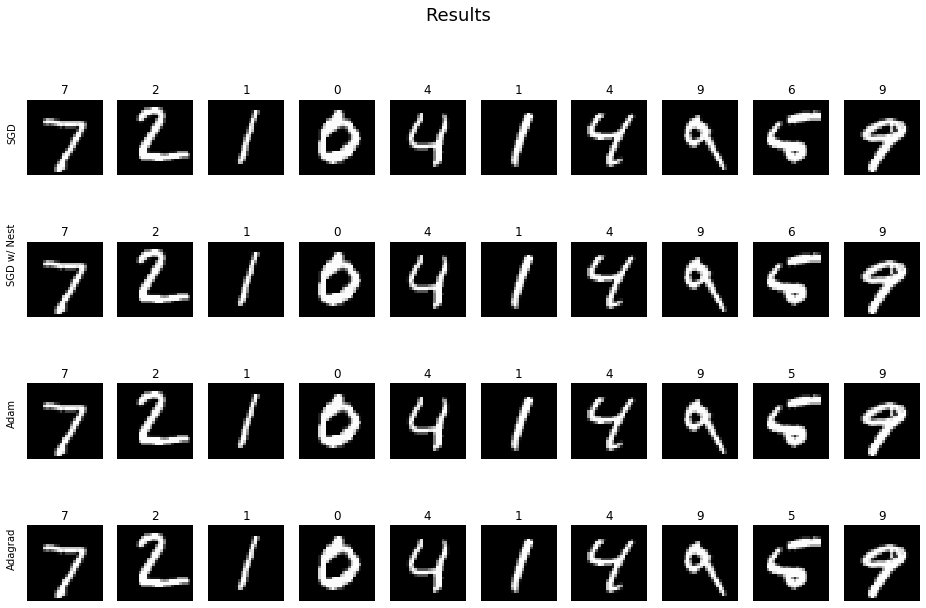

In [22]:
fig, axs = plt.subplots(nrows=len(models), ncols=10, figsize=(16, 10))
fig.suptitle('Results', fontsize=18)
for i_model, (label, model) in enumerate(models.items()):  

    X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
    predictions = model.predict(X_test)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

    for i in range(10):    
        axs[i_model][i].imshow(X_test[i, :, :, 0], cmap='gray')    
        axs[i_model][i].set_title(str(np.argmax(predictions[i])))    
        axs[i_model][i].axis('off') 
        
for ax, label in zip(axs[:,0], models.keys()):
    ax.text(-4, 15, label, horizontalalignment='right', rotation = 90)
    
plt.show()

#### Commento
Dall'andamento dell'accuracy e della loss si vede che gli ottimizzatori Adam e Adagrad hanno risultati migliori. SDG con e senza Nesterov si ferma attorno al 95% di accuracy, mentre gli altri due arrivano al 98%.

Per gli esempi che abbiamo stampato, si vede che il numero 5 scritto con calligrafia abbastanza "frettolosa" non viene confuso per un 6 da SGD, anche nell'implementazione con momento di Nesterov.

## Esercizio 12.2: Rete Neurale Convoluzionale (CNN)
Utilizziamo ora una rete neurale convoluzionale. La struttura scelta presenta:
- Layer Convoluzionale con 6 filtri che agiscono con kernel 5 x 5, con padding
- Dropout con probabilità 0.2
- Layer Max Pooling con pool 2 x 2, stride = 2, padding
- Layer flat di 30 neuroni , attivazione relu
- Layer di output di 10 neuroni con attivazione softmax

In [14]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [15]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 6 filters (dimensionality of output space)
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu', padding='same',
                     input_shape=input_shape))
   
    model.add(Dropout(0.2))

    # Add a middle pooling layer, and then some.
    model.add(MaxPooling2D(
        pool_size = (2, 2),
        strides = 2,
        padding = "same"
    ))
    
    # Add a Flatten model to transition from a convolution layer to a
    # linear layer.
    model.add(Flatten())

    model.add(Dense(
        30,
        activation = "relu"
    ))
    
    # The finaly layer is necessarily a ten-neurons linear layer,
    # since it must classify the data in ten classes.
    model.add(Dense(
        10,
        activation = "softmax"
    ))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    return model

In [18]:
# training parameters
batch_size = 32
epochs = 20

# create the deep conv net
model_CNN=create_CNN()

model_CNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1176)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)                35310     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                310       
Total params: 35,776
Trainable params: 35,776
Non-trainable params: 0
__________________________________________________

In [19]:
# train CNN
history_CNN = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 18s 302us/step - loss: 0.4694 - accuracy: 0.8638 - val_loss: 0.2762 - val_accuracy: 0.9242
Epoch 2/20
60000/60000 [==============================] - 18s 298us/step - loss: 0.2478 - accuracy: 0.9272 - val_loss: 0.2187 - val_accuracy: 0.9426
Epoch 3/20
60000/60000 [==============================] - 18s 298us/step - loss: 0.1989 - accuracy: 0.9427 - val_loss: 0.1839 - val_accuracy: 0.9536
Epoch 4/20
60000/60000 [==============================] - 18s 301us/step - loss: 0.1642 - accuracy: 0.9522 - val_loss: 0.1549 - val_accuracy: 0.9593
Epoch 5/20
60000/60000 [==============================] - 19s 311us/step - loss: 0.1368 - accuracy: 0.9595 - val_loss: 0.1307 - val_accuracy: 0.9643
Epoch 6/20
60000/60000 [==============================] - 19s 322us/step - loss: 0.1178 - accuracy: 0.9653 - val_loss: 0.1140 - val_accuracy: 0.9674
Epoch 7/20
60000/60000 [==============================] 

In [20]:
# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss: {:.3f}'.format(score[0]))
print('Test accuracy: {:.3f}'.format(score[1]))

10000/10000 [==============================] - 1s 127us/step

Test loss: 0.052
Test accuracy: 0.983


## Esercizio 12.3

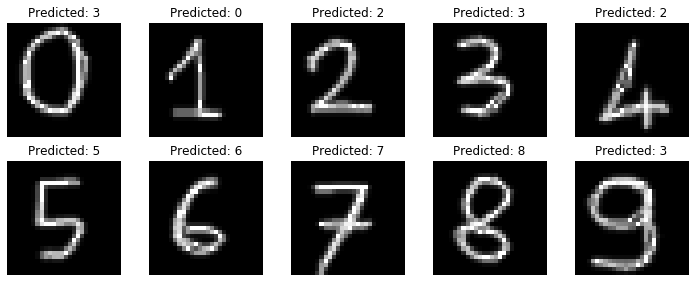

In [21]:
from PIL import Image
import os

prefix = "digits/"
suffix = ".png"
digits = [str(d) for d in range(10)]
img_width = 28
img_height = 28

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (2 * 5, 2 * 2))
axes = axes.flatten()

for d_count, digit in zip(range(10), digits):
    filename = prefix + digit + suffix
    digit_image = Image.open(filename).convert('L')

    ydim, xdim = digit_image.size
    pix = digit_image.load()
    data = np.zeros((xdim, ydim))
    
    # Transpose manually the image
    for j in range(ydim):
        for i in range(xdim):
            data[i,j] = pix[j,i]

    # Rescale the data from [0, 255] to [0, 1].
    data /= 255
    axes[d_count].imshow(data, cmap = "gray")

    # Reshape the input data.
    # The first argument for "reshape" is the number of samples,
    # so here it is just 1
    if keras.backend.image_data_format() == "channels_first":
        data = data.reshape(1, 1, img_width, img_height)
    else:
        data = data.reshape(1, img_width, img_height, 1)
    
    axes[d_count].axis("off")
    axes[d_count].set_title("Predicted: " + str(np.argmax(model_CNN.predict(data))))

fig.tight_layout()
plt.show()

#### Commento
6 giusti e 4 sbagliati. Non buono. Tuttavia sul dataset di validazione l'accuracy è al 98%. Significa che la rete non si è allenata in modo sufficientemente generale. C'è anche da dire che i numeri utilizzati in questo ultimo test non sono nitidi come nel dataset MNIST.